In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets

import warnings
warnings.simplefilter("ignore")

import chart_studio.plotly as py

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

import seaborn as sns

In [3]:
# read the csv file into a DataFrame
df = pd.read_csv("D:/Projects/Global-Temperature-Change-Prediction-master/Data/GlobalLandTemperaturesByCity.csv")

# convert first column to DateTime format
df['dt'] = pd.to_datetime(df['dt'])

# set first column (dt) as the index column
df.index = df['dt']
del df['dt']

# dropping AverageTemperatureUncertainty, Latitude and Longitude and combining City and Country into City
df = df.drop({"AverageTemperatureUncertainty", "Latitude", "Longitude"}, 1)
df["City"] = df["City"] + ", " + df["Country"]
df = df.drop("Country", 1)

# removing all rows with NaN values
df = df.dropna()

# get list of all cities in dataset
cities = set(df.City)

In [4]:
# check stationarity in time series data of a given city

def check_stationarity(city_df):
    # method1: plot the time series to check for trend and seasonality
    city_df.plot(figsize=(10, 10))
    
    # method 2: check if histogram fits a Gaussian Curve, then split data into two parts, calculate means and variances and see if they vary
    city_df.hist(figsize=(10, 10))
    plt.show()
    
    X = city_df["AverageTemperature"].values
    split = int(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print('mean1=%f, mean2=%f' % (mean1, mean2))
    print('variance1=%f, variance2=%f' % (var1, var2))
    
    # if corresponding means and variances differ slightly (by less than 10), we consider that the time series might be stationary
    if (abs(mean1-mean2) <= 10 and abs(var1-var2) <= 10):
        print("Time Series may be Stationary, since means and variances vary only slightly.\n")
    else:
        print("Time Series may NOT be Stationary, since means and variances vary significantly.\n")
        
    # method3: statistical test (Augmented Dickey-Fuller statistic)
    print("Performing Augmented Dickey-Fuller Test to confirm stationarity...")
    
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    
    p = result[1]
    if (p > 0.05):
        print("Time Series is NOT Stationary, since p-value > 0.05")
        city_df = city_df.diff()  # differencing to make data stationary
        return False
    else:
        print("Time Series is Stationary, since p-value <= 0.05")
        return True

In [5]:
# check stationarity for data of a specific city entered by the user

city_drop_down_menu = widgets.Dropdown(
    options=sorted(list(cities)),
    value='New York, United States',
    description='City:',
    disabled=False,
)

city_drop_down_menu

Dropdown(description='City:', index=2117, options=('A Coruña, Spain', 'Aachen, Germany', 'Aalborg, Denmark', '…

In [6]:
chosen_city = city_drop_down_menu.value
city_df = df[df.City == chosen_city].drop("City", 1)

Stationarity Check for New York, United States


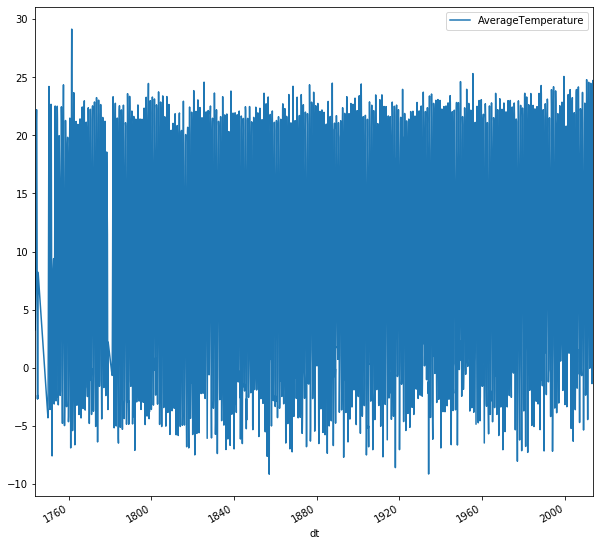

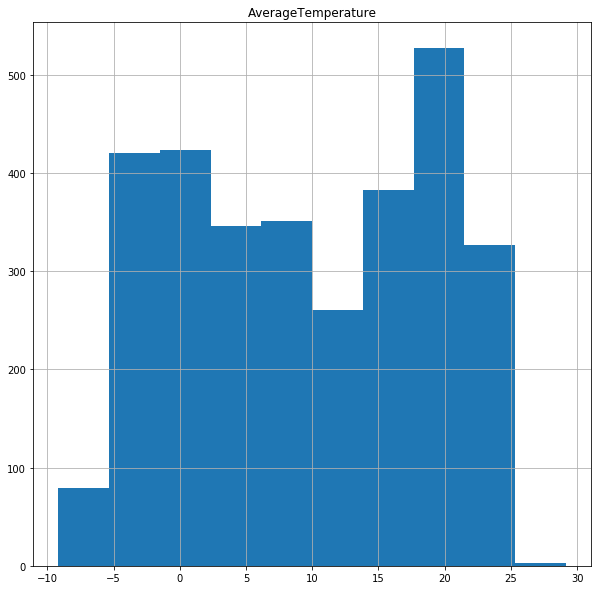

mean1=9.117772, mean2=9.928560
variance1=86.640935, variance2=84.126356
Time Series may be Stationary, since means and variances vary only slightly.

Performing Augmented Dickey-Fuller Test to confirm stationarity...
ADF Statistic: -5.157735
p-value: 0.000011
Time Series is Stationary, since p-value <= 0.05


In [7]:
print ("Stationarity Check for %s" % chosen_city)
is_stationary = check_stationarity(city_df)

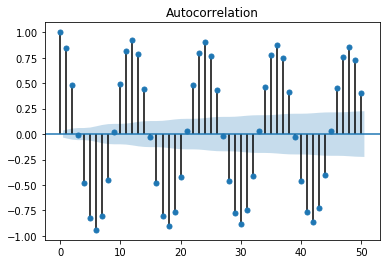

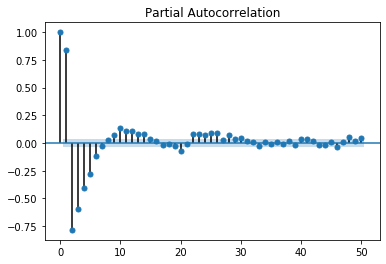

In [8]:
# ACF and PACF plots

plot_acf(city_df,lags = 50)
plot_pacf(city_df,lags = 50)
plt.show()

# setting d value for ARIMA model
if (is_stationary==True):
    d = 0
else:
    d = 1

In [9]:
# Although we can determine p, q values manually by looking at the ACF and PACF plots for a given city, we must automate the process
# To automate the process, we must perform a grid search over different values of p and q and choose the ARIMA model for which the AIC and BIC values are minimum

p_range = q_range = list(range(0,3))  # taking values from 0 to 2

aic_values = []
bic_values = []
pq_values = []

for p in p_range:
    for q in q_range:
        try:
            model = ARIMA(city_df, order=(p, d, q))
            results = model.fit(disp=-1)
            aic_values.append(ARMAResults.aic(results))
            bic_values.append(ARMAResults.bic(results))
            pq_values.append((p, q))
        except:
            pass

best_pq = pq_values[aic_values.index(min(aic_values))]  # (p,q) corresponding to lowest AIC score
print("(p,q) corresponding to lowest AIC score: ", best_pq)

(p,q) corresponding to lowest AIC score:  (2, 2)


In [10]:
# fitting an ARIMA model with chosen p, d, q values and calculating the mean squared error
from sklearn.metrics import mean_absolute_error

arima_model = ARIMA(city_df, order=(best_pq[0], 0, best_pq[1])).fit()
predictions = arima_model.predict(start=0, end=len(city_df)-1)

mse = mean_squared_error(list(city_df.AverageTemperature), list(predictions))
print("Mean Squared Error:", mse)

mae = mean_absolute_error(list(city_df.AverageTemperature), list(predictions))
print("Mean Absolute Error:", mae)

Mean Squared Error: 4.678030475807863
Mean Absolute Error: 1.5780002360009977


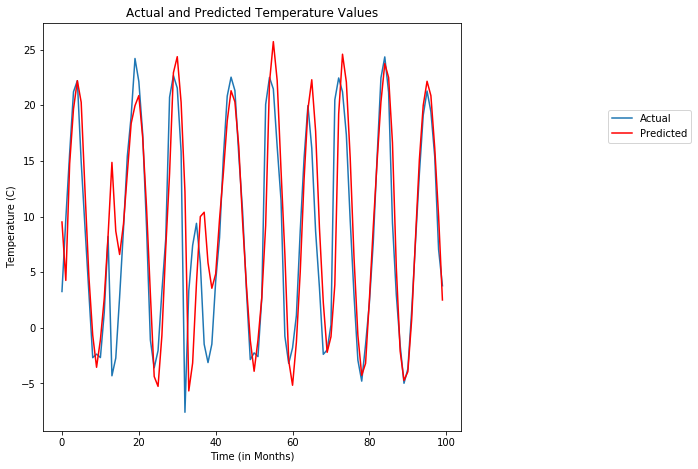

In [11]:
# comparing first 100 predictions with actual values

plt.figure(figsize=(7.5,7.5))
plt.plot(list(city_df.AverageTemperature)[:100], label="Actual")
plt.plot(list(predictions)[:100], 'r', label="Predicted")

plt.xlabel("Time (in Months)")
plt.ylabel("Temperature (C)")
plt.title("Actual and Predicted Temperature Values")

plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8))
plt.show()

In [12]:
# drop-down menu to select number of years for which predictions are required

years_drop_down_menu = widgets.Dropdown(
    options=list(range(1,201)),
    value=10,
    description='No. of Years:',
    disabled=False,
)

years_drop_down_menu

Dropdown(description='No. of Years:', index=9, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,…

In [13]:
num_years = years_drop_down_menu.value
last_month_in_dataset = city_df.index[-1].month  # gets last month in city_df
remaining_months = 12 - last_month_in_dataset  # months left in current year for that city's data
number_of_steps = remaining_months + num_years * 12  # number of steps to make out-of-sample predictions

out_of_sample_forecast = arima_model.forecast(steps=number_of_steps)[0]  # predictions

out_of_sample_forecast = out_of_sample_forecast[remaining_months:]  # excluding predictions for remaining months in current year

In [14]:
# displaying forecasted values for the nth year

months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
i = 0
for x in out_of_sample_forecast[-12:]:  # last year
    print(months[i]+": ", x, 'C')
    i += 1

January:  2.147347978509124 C
February:  4.259366311331378 C
March:  7.76582047697134 C
April:  11.706925831234912 C
May:  15.015450792126302 C
June:  16.805613457006746 C
July:  16.61010641824079 C
August:  14.501858488858424 C
September:  11.068870422546059 C
October:  7.250405846441925 C
November:  4.080123074686869 C
December:  2.4063651038721035 C


In [15]:
# plotting the predicted values for the nth year

trace = go.Scatter(
    x = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"],
    y = out_of_sample_forecast[-12:],
    mode = 'lines',
    name = 'Average Temperature'
)

layout = go.Layout(
    title='Predicted Temperatures for the Year %d' % (2013+num_years),
    xaxis=dict(
        title='Year',
    ),
    yaxis=dict(
        title='Temperature (C)',
    )
)
data = [trace]

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [19]:
# plotting monthly temperature changes from 2013 to 2013+n years

monthly_change = {}

for month in range(12):
    temp = month
    for year in range(num_years):
        if month not in monthly_change:
            monthly_change[month] = [out_of_sample_forecast[temp]]
        else:
            monthly_change[month].append(out_of_sample_forecast[temp])
        temp+=12
        


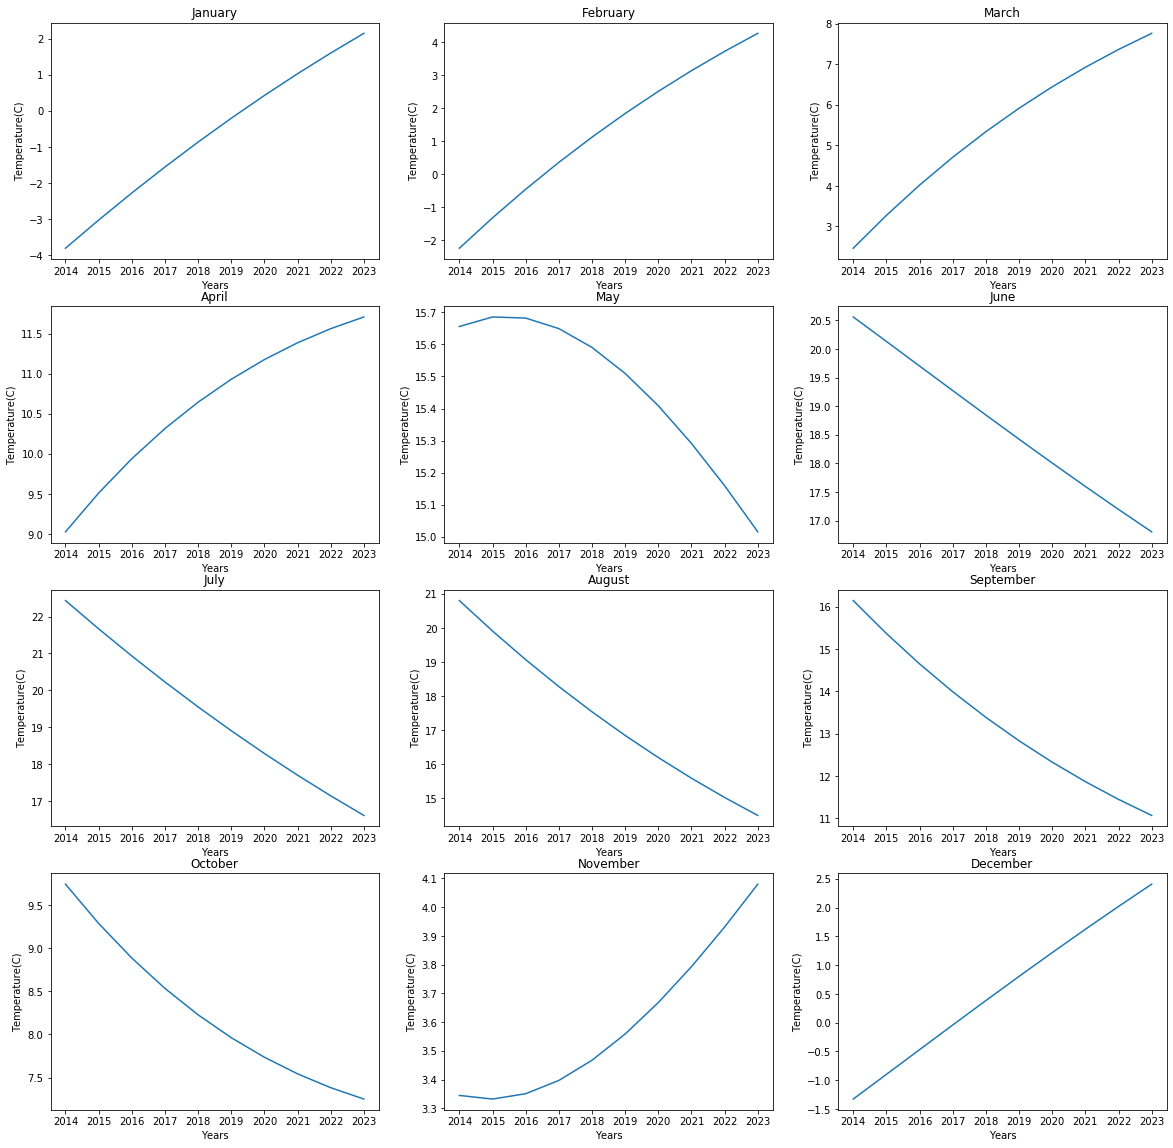

In [21]:

plt.figure(figsize=(20,20))
for pos in range(0,12):
    plt.subplot(4,3,pos+1)
    plt.plot(monthly_change[pos])
    plt.xticks(np.array(range(num_years)), [i for i in range(2014,2014+num_years)])
    plt.title(months[pos])
    plt.xlabel('Years')
    plt.ylabel('Temperature(C)')

plt.show()

When we forecasted the future temperature values for New York, we could infer from the above plots that the summers seem to be getting cooler and the winters seem to be getting warmer over the next decade.<br>

We have also analyzed the factors that might possibly affect temperature change.

###  The Effect of Pollution and Greenhouse Gases on Temperature Change
For the sake of simplicity, we have only considered the effect of pollution and Greenhouse Gases on temperature change in New York from 2013-2023.

#### Effect of Pollution on Temperature Change

In [29]:
df = pd.read_csv('D:/Projects/Global-Temperature-Change-Prediction-master/Data/pollution.csv')
new_df = df.drop(['Unnamed: 0','State Code', 'County Code', 'Site Num', 'Address',
       'State', 'County', 'NO2 Units', 'NO2 Mean',
       'NO2 1st Max Value', 'NO2 1st Max Hour', 'O3 Units',
       'O3 Mean', 'O3 1st Max Value', 'O3 1st Max Hour', 'SO2 Units',
       'SO2 Mean', 'SO2 1st Max Value', 'SO2 1st Max Hour','CO Units', 'CO Mean','CO 1st Max Value', 'CO 1st Max Hour'],axis = 1)

In [30]:
# For NO2

# Get only the NO2 AQI values and Date Local
no2_df = new_df.drop(['O3 AQI', 'SO2 AQI', 'CO AQI'],1)

# Every day has multiple values, so we will take only the maximum values of NO2 AQI every day
no2_df = no2_df.sort_values('NO2 AQI', ascending = 0).drop_duplicates(subset='Date Local', keep='first')

# Convert Date Local to datatime format
no2_df['Date Local'] = pd.to_datetime(no2_df['Date Local'])
no2_df.index = no2_df['Date Local']
del no2_df['Date Local']

# Consider only New York City
no2_df = no2_df[no2_df['City'] == 'New York']

# Calculate mean N02 AQI per year
no2_df = no2_df.resample("A").mean()
no2_df= no2_df.sort_index()
no2_df = no2_df.dropna()

#-----------------------------------------------------------------------------------------------------------------#

# For SO2
so2_df = new_df.drop(['O3 AQI', 'NO2 AQI', 'CO AQI'],1)
so2_df = so2_df.sort_values('SO2 AQI',ascending = 0).drop_duplicates(subset='Date Local', keep='first')
so2_df['Date Local'] = pd.to_datetime(so2_df['Date Local'])
so2_df.index = so2_df['Date Local']
del so2_df['Date Local']
so2_df = so2_df[so2_df['City'] == 'New York']
so2_df = so2_df.resample("A").mean()
so2_df= so2_df.sort_index()
so2_df = so2_df.dropna()
so2_df.head()

#-----------------------------------------------------------------------------------------------------------------#

# For CO
co_df = new_df.drop(['SO2 AQI', 'NO2 AQI', 'O3 AQI'],1)
co_df = co_df.sort_values('CO AQI',ascending = 0).drop_duplicates(subset='Date Local', keep='first')
co_df['Date Local'] = pd.to_datetime(co_df['Date Local'])
co_df.index = co_df['Date Local']
del co_df['Date Local']
co_df = co_df[co_df['City'] == 'New York']
co_df = co_df.resample("A").mean()
co_df= co_df.sort_index()
co_df = co_df.dropna()


In [32]:
# Data Cleaning for Temperature Data where we are only considering the Temperature for New York City
df = pd.read_csv("D:/Projects/Global-Temperature-Change-Prediction-master/Data/GlobalLandTemperaturesByCity.csv")
df = df[df['Country'] == 'United States']
df = df[df['City'] == 'New York']
df = df.drop({"AverageTemperatureUncertainty", "Latitude", "Longitude"}, 1)

# Convert the Date Local column to date time format
df['Date Local'] = pd.to_datetime(df['dt'])
# set first column (dt) as the index column
df.index = df['Date Local']
del df['dt'],df['City'],df['Country']
df.dropna()

# As we have only one value per day we dont need to drop duplicates so this will calculate the Annual Mean Temperature
df = df.resample("A").mean()

df = df.dropna()
df = df.sort_index()

In [33]:
# Joining different Pollution Data with the Temperature Data

j1 = pd.merge(df, no2_df, left_index = True, right_index = True, how='inner')
j2 = pd.merge(so2_df, j1, left_index = True, right_index = True, how='inner')
j3 = pd.merge(co_df, j2, left_index = True, right_index = True, how='inner')
j3.head()

,CO AQI,SO2 AQI,AverageTemperature,NO2 AQI
Date Local,,,,
2000-12-31,30.250000,62.476190,9.969083,70.000000
2001-12-31,19.000000,61.285714,10.931000,75.735294
2002-12-31,17.625000,59.342105,11.252167,71.692308
2003-12-31,19.357143,59.388889,9.836000,66.148148
2004-12-31,15.538462,53.675676,10.389500,64.921053


In [34]:
# Normalize the data so that all the column data can be compared
j3_norm = (j3 - j3.mean()) / (j3.max() - j3.min())
j3_norm.head()

,CO AQI,SO2 AQI,AverageTemperature,NO2 AQI
Date Local,,,,
2000-12-31,0.654585,0.357917,-0.404637,0.347543
2001-12-31,0.132401,0.329215,0.008577,0.575799
2002-12-31,0.068578,0.282354,0.146542,0.414894
2003-12-31,0.148978,0.283482,-0.461806,0.194245
2004-12-31,-0.028272,0.145735,-0.224037,0.145408


In [35]:
# Plotting the data
trace0 = go.Scatter(
    x = j3_norm.index,
    y = j3_norm['AverageTemperature'],
    mode = 'lines',
    name = 'Temperature'
)

trace1 = go.Scatter(
    x = j3_norm.index,
    y = j3_norm['CO AQI'],
    mode = 'lines',
    name = 'Carbon Monoxide'
)

trace3 = go.Scatter(
    x = j3_norm.index,
    y = j3_norm['SO2 AQI'],
    mode = 'lines',
    name = 'Sulphur Dioxide'
)

trace4 = go.Scatter(
    x = j3_norm.index,
    y = j3_norm['NO2 AQI'],
    mode = 'lines',
    name = 'Nitrogen Dioxide'
)

layout = go.Layout(
    title='Temperature and Pollution Plots',
    xaxis=dict(
        title='Year',
    ),
    yaxis=dict(
        title='Normalized Values',
    )
)

data = [trace0,trace1,trace3,trace4]
fig = go.Figure(data=data, layout=layout)
iplot(fig)

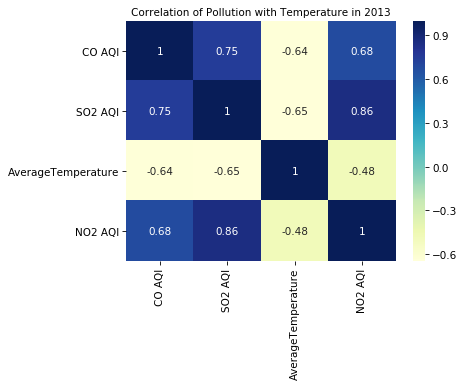

In [36]:
# Plotting the correlation matrix for Pollution vs. Temperature

fig = plt.figure(dpi = 75)

ax = fig.add_axes([0.1, 0.1, 0.75, 0.8]) 
sns.heatmap(j3_norm.corr(method='pearson'), annot = True, cmap="YlGnBu")
ax.set_title("Correlation of Pollution with Temperature in 2013", fontsize=10)
plt.show()

#### SECTION 2: Greenhouse Gases and Temperature Change
Source of Greenhouse Gases data: <a href="https://www.kaggle.com/unitednations/international-greenhouse-gas-emissions" target="_blank">International Greenhouse Gas Emissions</a> from Kaggle.

In [38]:
df = pd.read_csv("D:/Projects/Global-Temperature-Change-Prediction-master/Data/GlobalLandTemperaturesByCity.csv")

# convert first column to DateTime format
df['dt'] = pd.to_datetime(df['dt'])

# set first column (dt) as the index column
df.index = df['dt']
del df['dt']

df = df.drop({"AverageTemperatureUncertainty", "Latitude", "Longitude","Country"}, 1)

df = df.dropna()

df = df[df['City']=='New York']
df = df.drop({'City'},1)
df = df.resample("A").mean()

In [41]:
gg_df = pd.read_csv("D:/Projects/Global-Temperature-Change-Prediction-master/Data/greenhouse_gas_inventory_data_data.csv")

df_usa = gg_df[gg_df['country_or_area']=='United States of America'].drop('country_or_area', 1)

# getting yearly emissions for the 4 major greenhouse gases i.e. CO2, Methane, Nitrous Oxide and HCFCs
df_usa_co2 = df_usa[df_usa['category']=='carbon_dioxide_co2_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent'].drop('category', 1)
df_usa_co2 = df_usa_co2.sort_values('year')
df_usa_co2.columns=['year','co2']

df_usa_methane = df_usa[df_usa['category']=='methane_ch4_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent'].drop('category', 1)
df_usa_methane = df_usa_methane.sort_values('year')
df_usa_methane.columns=['year','methane']

df_usa_n2o = df_usa[df_usa['category']=='nitrous_oxide_n2o_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent'].drop('category', 1)
df_usa_n2o = df_usa_n2o.sort_values('year')
df_usa_n2o.columns=['year','n2o']

df_usa_hcfc = df_usa[df_usa['category']=='hydrofluorocarbons_hfcs_emissions_in_kilotonne_co2_equivalent'].drop('category', 1)
df_usa_hcfc = df_usa_hcfc.sort_values('year')
df_usa_hcfc.columns=['year','hcfc']

# Set Index
df_usa_co2.index = df_usa_co2['year']
df_usa_methane.index = df_usa_methane['year']
df_usa_n2o.index = df_usa_n2o['year']
df_usa_hcfc.index = df_usa_hcfc['year']

del df_usa_co2['year'],df_usa_methane['year'],df_usa_n2o['year'],df_usa_hcfc['year']

In [42]:
co2 = df_usa_co2['co2']
n2o = df_usa_n2o['n2o']
methane = df_usa_methane['methane']
hcfc = df_usa_hcfc['hcfc']
temp = list(df['AverageTemperature'])[-25:]

part3 = pd.DataFrame({'co2':co2,'n2o':n2o,'methane':methane,'hcfc':hcfc,'temp': temp},columns = ['co2','n2o','methane','hcfc','temp'])
part3.head()

,co2,n2o,methane,hcfc,temp
year,,,,,
1990,5.115095e+06,406228.526626,773854.896420,46288.814184,9.661333
1991,5.064880e+06,396113.656867,777034.220915,41618.413588,11.322500
1992,5.170274e+06,404052.107073,776869.789752,47427.662176,11.357250
1993,5.284759e+06,420503.190940,764089.671267,47500.262267,9.572667
1994,5.377492e+06,402478.930460,770450.426146,53246.654974,10.040917


In [43]:
# normalizing the values

part3_norm = (part3 - part3.mean()) / (part3.max() - part3.min())

In [44]:
# Plotting values for Greenhouse Gases along with Temperature

trace0 = go.Scatter(
    x = part3_norm.index,
    y = part3_norm['temp'],
    mode = 'lines',
    name = 'Temperature'
)

trace1 = go.Scatter(
    x = part3_norm.index,
    y = part3_norm['co2'],
    mode = 'lines',
    name = 'Carbon Dioxide'
)

trace2 = go.Scatter(
    x = part3_norm.index,
    y = part3_norm['n2o'],
    mode = 'lines',
    name = 'Nitrous Oxide'
)

trace3 = go.Scatter(
    x = part3_norm.index,
    y = part3_norm['methane'],
    mode = 'lines',
    name = 'Methane'
)

trace4 = go.Scatter(
    x = part3_norm.index,
    y = part3_norm['hcfc'],
    mode = 'lines',
    name = 'Hydrofluorocarbon'
)


layout = go.Layout(
    title='Temperature and Greenhouse Gases Plots',
    xaxis=dict(
        title='Year',
    ),
    yaxis=dict(
        title='Normalized Values',
    )
)

data = [trace0,trace1,trace2,trace3,trace4]
fig = go.Figure(data=data, layout=layout)
iplot(fig)


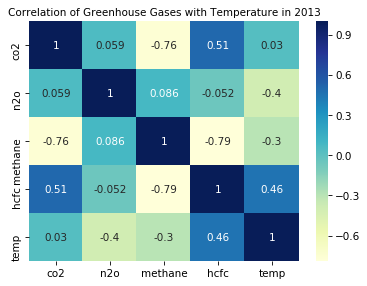

In [45]:
# Plotting the correlation matrix for the Greenhouse Gases

fig = plt.figure(dpi = 75)

ax = fig.add_axes([0.1, 0.1, 0.75, 0.8]) 
sns.heatmap(part3.corr(method='pearson'), annot = True, cmap="YlGnBu")
ax.set_title("Correlation of Greenhouse Gases with Temperature in 2013", fontsize=10)
plt.show()

From the above correlation matrix, we can infer that HCFCs (HydroChloroFluoroCarbons) have the most impact on temperature.<br>
We now predict the future Greenhouse Gas emissions and their impact on future temperature values from 2013-2023.

In [46]:
l = [df_usa_methane, df_usa_hcfc, df_usa_n2o, df_usa_co2]

future_values = []


# Calculating AIC and BIC values for all Greenhouse Gases
for gas in l:

    p_range = q_range = list(range(0,3))  # taking values from 0 to 2
    
    # Directly converting the index of gas dataframe changes it to become a DateTimeIndex so we converted and saved it to a temporary dataframe
    temp = pd.to_datetime(gas.index,format = '%Y')
    gas['year'] = temp
    gas.set_index('year',inplace=True)
    
    aic_values = []
    bic_values = []
    pq_values = []
    
    for p in p_range:
        for q in q_range:
            try:
                model = ARIMA(gas, order=(p, 0, q))
                results = model.fit(disp=-1)
                aic_values.append(ARMAResults.aic(results))
                bic_values.append(ARMAResults.bic(results))
                pq_values.append((p, q))
            except:
                pass

    # (p,q) corresponding to lowest AIC score
    best_pq = pq_values[aic_values.index(min(aic_values))]  

    arima_model = ARIMA(gas, order=(best_pq[0], 0, best_pq[1])).fit()
    out_of_sample_forecast = arima_model.forecast(steps=10)[0]
   
    for i in out_of_sample_forecast:
        future_values.append(i)

# Separating and storing them in different lists which will then be converted to a dataframe
future_methane = future_values[:10]
future_co2 = future_values[30:40]
future_hcfc = future_values[10:20]

# Data Frame that stores predicted Greenhouse gas values
future_gg = pd.DataFrame({'Methane':future_methane,'CO2':future_co2,'HCFC':future_hcfc},columns = ['Methane','CO2','HCFC'])
future_gg.head()

,Methane,CO2,HCFC
0,735919.447202,5.566013e+06,156680.327190
1,738676.268471,5.575096e+06,158298.390251
2,740157.875322,5.583340e+06,157874.340271
3,740944.902128,5.590823e+06,156031.502475
4,741355.358867,5.597614e+06,153247.244439


In [48]:
# Predicting future annual temperature values across the next 10 years for New York

ny_df = pd.read_csv("D:/Projects/Global-Temperature-Change-Prediction-master/Data/GlobalLandTemperaturesByCity.csv")
ny_df = ny_df[ny_df['Country'] == 'United States']
ny_df = ny_df[ny_df['City'] == 'New York']
ny_df = ny_df.drop({"AverageTemperatureUncertainty", "Latitude", "Longitude"}, 1)

# Convert the Date Local column to date time format
ny_df['Date Local'] = pd.to_datetime(ny_df['dt'])
# set first column (dt) as the index column
ny_df.index = ny_df['Date Local']
del ny_df['dt'], ny_df['City'], ny_df['Country']
ny_df.dropna()

# As we have only one value per day we dont need to drop duplicates so this will calculate the Annual Mean Temperature
ny_df = ny_df.resample("A").mean()

ny_df = ny_df.dropna()
ny_df = ny_df.sort_index()

# fitting an ARIMA model

p_range = q_range = list(range(0,3))  # taking values from 0 to 2

aic_values = []
bic_values = []
pq_values = []

for p in p_range:
    for q in q_range:
        try:
            model = ARIMA(ny_df, order=(p, d, q))
            results = model.fit(disp=-1)
            aic_values.append(ARMAResults.aic(results))
            bic_values.append(ARMAResults.bic(results))
            pq_values.append((p, q))
        except:
            pass

best_pq = pq_values[aic_values.index(min(aic_values))]  # (p,q) corresponding to lowest AIC score
print("(p,q) corresponding to lowest AIC score: ", best_pq)

arima_model = ARIMA(ny_df, order=(best_pq[0], 0, best_pq[1])).fit()

ny_out_of_sample_forecast = arima_model.forecast(steps=10)[0]

future_gg['Temperature'] = ny_out_of_sample_forecast

(p,q) corresponding to lowest AIC score:  (2, 1)


In [49]:
# Normalizing the predicted values

part3_norm = (future_gg - future_gg.mean()) / (future_gg.max() - future_gg.min())
part3_norm.head()

,Methane,CO2,HCFC,Temperature
0,-0.796941,-0.563783,0.311483,-0.338744
1,-0.321727,-0.405083,0.381042,0.623569
2,-0.066331,-0.261039,0.362813,0.283784
3,0.069335,-0.130297,0.283590,0.229080
4,0.140089,-0.011629,0.163896,0.114531


In [50]:
# Plotting predicted values for Greenhouse Gases with predicted temperature values for New York

future_years = ['2014','2015','2016','2017','2018','2019','2020','2021','2022','2023']
trace0 = go.Scatter(
    x = future_years,
    y = part3_norm['Methane'],
    mode = 'lines',
    name = 'Methane'
)

trace1 = go.Scatter(
    x = future_years,
    y = part3_norm['HCFC'],
    mode = 'lines',
    name = 'HCFC'
)


trace2 = go.Scatter(
    x = future_years,
    y = part3_norm['CO2'],
    mode = 'lines',
    name = 'CO2'
)

trace3 = go.Scatter(
    x = future_years,
    y = part3_norm['Temperature'],
    mode = 'lines',
    name = 'Temperature'
)


layout = go.Layout(
    title='Predicted Temperature and Greenhouse Gases Plots',
    xaxis=dict(
        title='Year',
    ),
    yaxis=dict(
        title='Normalized Values',
    )
)

data = [trace0,trace1,trace3]
fig = go.Figure(data=data, layout=layout)
iplot(fig)

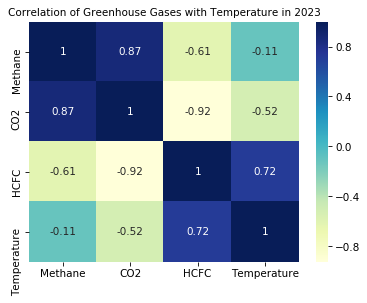

In [51]:
# Plotting the correlation matrix for the Greenhouse Gases with Temperature

fig = plt.figure(dpi = 75)

ax = fig.add_axes([0.1, 0.1, 0.75, 0.8]) 
sns.heatmap(part3_norm.corr(method='pearson'), annot = True, cmap="YlGnBu")
ax.set_title("Correlation of Greenhouse Gases with Temperature in 2023", fontsize=10)
plt.show()

From the above correlation matrix, we can infer that HCFCs (HydroChloroFluoroCarbons) will still have the highest impact on temperature.<br>Steps must be taken to reduce the emission of HCFCs to reduce their impact on temperature.

## Conclusion

In this project, we:

<ul>
<li>Forecasted the temperature of a given city over a given period of time</li>
<li>Analyzed the correlation between pollution levels and temperature, as well as the correlation between Greenhouse gas emissions and temperature, which helped us identify the Greenhouse Gas that has and will have the most impact on temperature change.</li>
</ul>